# Database comparisons
The purpose of this notebook is to evaluate classification accuracy between different reference databases. Select mock community sequences are taxonomically classified using two or more different reference databases, e.g., Greengenes 13_8 [trimmed to 250 nt](./generate-tax-assignments.ipynb) and the same database [trimmed to 150 nt](./generate-tax-assignments-trimmed-dbs.ipynb). [This notebook](./generate-tax-assignments-trimmed-dbs.ipynb) can also be modified to provide taxonomic classification with any number of desired reference databases/versions. Limit the analysis to only a few mock communities and method/parameter combinations; the goal here is to compare the databases, not the methods.

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
%matplotlib inline

from os import environ
from os.path import join, exists, expandvars
import pandas as pd
from IPython.display import display

from tax_credit.framework_functions import (pointplot_from_data_frame,
                                            per_level_kruskal_wallis)
from tax_credit.eval_framework import (get_expected_tables_lookup, 
                                       find_and_process_result_tables,
                                       compute_mock_results,
                                       compute_mantel,
                                       generate_pr_scatter_plots,
                                       boxplot_from_data_frame,
                                       heatmap_from_data_frame,
                                       method_by_dataset_a1,
                                       method_by_dataset_a2,
                                       filter_table,
                                       evaluate_results,
                                       parameter_comparisons,
                                       method_by_dataset)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## short-read-tax-assignment repository. 
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")

## precomputed_results_dir is the directory containing taxonomy assignment
## results to compare. Defaults to the precomputed results in tax-credit
precomputed_results_dir = join(project_dir, "data/precomputed-results/")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(precomputed_results_dir, "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is just the precomputed 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [precomputed_results_dir]

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

In [3]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                taxonomy_level_range=range(2,7), 
                                min_count=1,
                                taxa_to_keep=None, 
                                md_key='a', 
                                subsample=False,
                                force=False)

/Users/nbokulich/Desktop/projects/short-read-tax-assignment/data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True


In [6]:
mock_results

Dataset  Level                SampleID         Reference  Method  \
0      mock-1      2          MockHiSeq.even      gg_13_8_otus     rdp   
1      mock-1      3          MockHiSeq.even      gg_13_8_otus     rdp   
2      mock-1      4          MockHiSeq.even      gg_13_8_otus     rdp   
3      mock-1      5          MockHiSeq.even      gg_13_8_otus     rdp   
4      mock-1      6          MockHiSeq.even      gg_13_8_otus     rdp   
325   mock-10      2                  Mock.1  unite_20.11.2016     rdp   
326   mock-10      2                  Mock.2  unite_20.11.2016     rdp   
327   mock-10      2                  Mock.3  unite_20.11.2016     rdp   
328   mock-10      3                  Mock.1  unite_20.11.2016     rdp   
329   mock-10      3                  Mock.2  unite_20.11.2016     rdp   
330   mock-10      3                  Mock.3  unite_20.11.2016     rdp   
331   mock-10      4                  Mock.1  unite_20.11.2016     rdp   
332   mock-10      4                  Mock.2  unite_20.11.2016     rdp   
333   mock-10      4                  Mock.3  unite_20.11.2016     rdp   
334   mock-10      5                  Mock.1  unite_20.11.2016     rdp   
335   mock-10      5                  Mock.2  unite_20.11.2016     rdp   
336   mock-10      5                  Mock.3  unite_20.11.2016     rdp   
337   mock-10      6                  Mock.1  unite_20.11.2016     rdp   
338   mock-10      6                  Mock.2  unite_20.11.2016     rdp   
339   mock-10      6                  Mock.3  unite_20.11.2016     rdp   
1300   mock-2      2          MockMiSeq.even      gg_13_8_otus     rdp   
1301   mock-2      3          MockMiSeq.even      gg_13_8_otus     rdp   
1302   mock-2      4          MockMiSeq.even      gg_13_8_otus     rdp   
1303   mock-2      5          MockMiSeq.even      gg_13_8_otus     rdp   
1304   mock-2      6          MockMiSeq.even      gg_13_8_otus     rdp   
1625   mock-3      2       HMPMockV1.1.Even1      gg_13_8_otus     rdp   
1626   mock-3      2       HMPMockV1.1.Even2      gg_13_8_otus     rdp   
1627   mock-3      2  HMPMockV1.2.Staggered1      gg_13_8_otus     rdp   
1628   mock-3      2  HMPMockV1.2.Staggered2      gg_13_8_otus     rdp   
1629   mock-3      3       HMPMockV1.1.Even1      gg_13_8_otus     rdp   
...       ...    ...                     ...               ...     ...   
8655   mock-8      2                   Even1      gg_13_8_otus  uclust   
8656   mock-8      2                   Even2      gg_13_8_otus  uclust   
8657   mock-8      2                   Even3      gg_13_8_otus  uclust   
8658   mock-8      3                   Even1      gg_13_8_otus  uclust   
8659   mock-8      3                   Even2      gg_13_8_otus  uclust   
8660   mock-8      3                   Even3      gg_13_8_otus  uclust   
8661   mock-8      4                   Even1      gg_13_8_otus  uclust   
8662   mock-8      4                   Even2      gg_13_8_otus  uclust   
8663   mock-8      4                   Even3      gg_13_8_otus  uclust   
8664   mock-8      5                   Even1      gg_13_8_otus  uclust   
8665   mock-8      5                   Even2      gg_13_8_otus  uclust   
8666   mock-8      5                   Even3      gg_13_8_otus  uclust   
8667   mock-8      6                   Even1      gg_13_8_otus  uclust   
8668   mock-8      6                   Even2      gg_13_8_otus  uclust   
8669   mock-8      6                   Even3      gg_13_8_otus  uclust   
9630   mock-9      2                  Mock.1  unite_20.11.2016  uclust   
9631   mock-9      2                  Mock.2  unite_20.11.2016  uclust   
9632   mock-9      2                  Mock.3  unite_20.11.2016  uclust   
9633   mock-9      3                  Mock.1  unite_20.11.2016  uclust   
9634   mock-9      3                  Mock.2  unite_20.11.2016  uclust   
9635   mock-9      3                  Mock.3  unite_20.11.2016  uclust   
9636   mock-9      4                  Mock.1  unite_20.11.2016  uclust   
9637   moc

Restrict analyses to a set of datasets or references: e.g., exclude taxonomy assignments made for purpose of reference database comparisons.

In [10]:
mock_results = mock_results[mock_results['Reference'] != 'gg_13_8_otus_trim150']

Evalution 1: Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. 

This is a qualitative evaluation, effectively telling us about the ability of the different methods to report the taxa that are present in each sample. These metrics are not concerned with the abundance of the different taxa.

As a first step, we will evaluate how accuracy metrics perform at each taxonomic level for each method within each reference dataset type.

In [4]:
color_pallette = dict(rdp="seagreen", sortmerna="gray", uclust="blue")

y_vars = ["Precision", "Recall", "F-measure"]

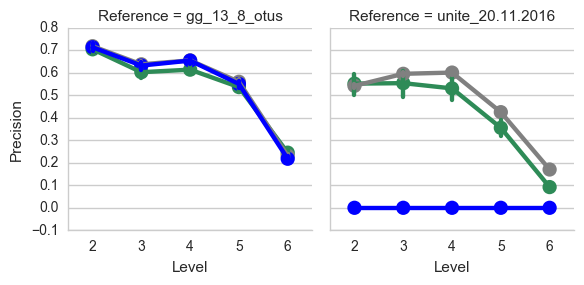

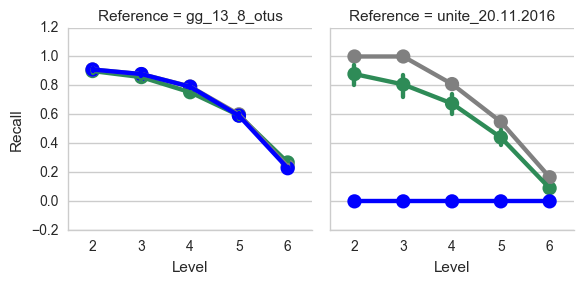

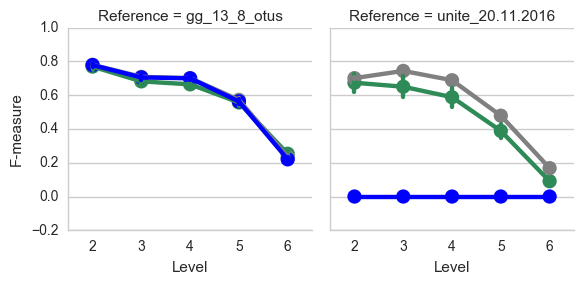

In [6]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Reference", color_by="Method",
                          color_pallette=color_pallette)

Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [11]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Method', 
                                  dataset_col='Reference', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset   Variable             2             3             4  \
0      gg_13_8_otus  Precision  1.779606e-01  5.404342e-04  1.243861e-05   
1      gg_13_8_otus     Recall  6.035836e-01  2.608572e-01  5.303693e-03   
2      gg_13_8_otus  F-measure  3.836402e-01  9.450360e-04  1.150314e-03   
3  unite_20.11.2016  Precision  5.541133e-54  3.241224e-52  1.774347e-52   
4  unite_20.11.2016     Recall  4.525882e-76  7.087683e-75  3.607193e-57   
5  unite_20.11.2016  F-measure  1.795372e-53  2.597918e-52  8.848744e-52   

              5             6  
0  4.806643e-02  6.080924e-02  
1  1.642057e-01  1.471172e-03  
2  6.103648e-02  4.442197e-02  
3  4.278789e-52  9.057667e-67  
4  5.714344e-53  1.065844e-75  
5  8.848744e-52  9.057667e-67

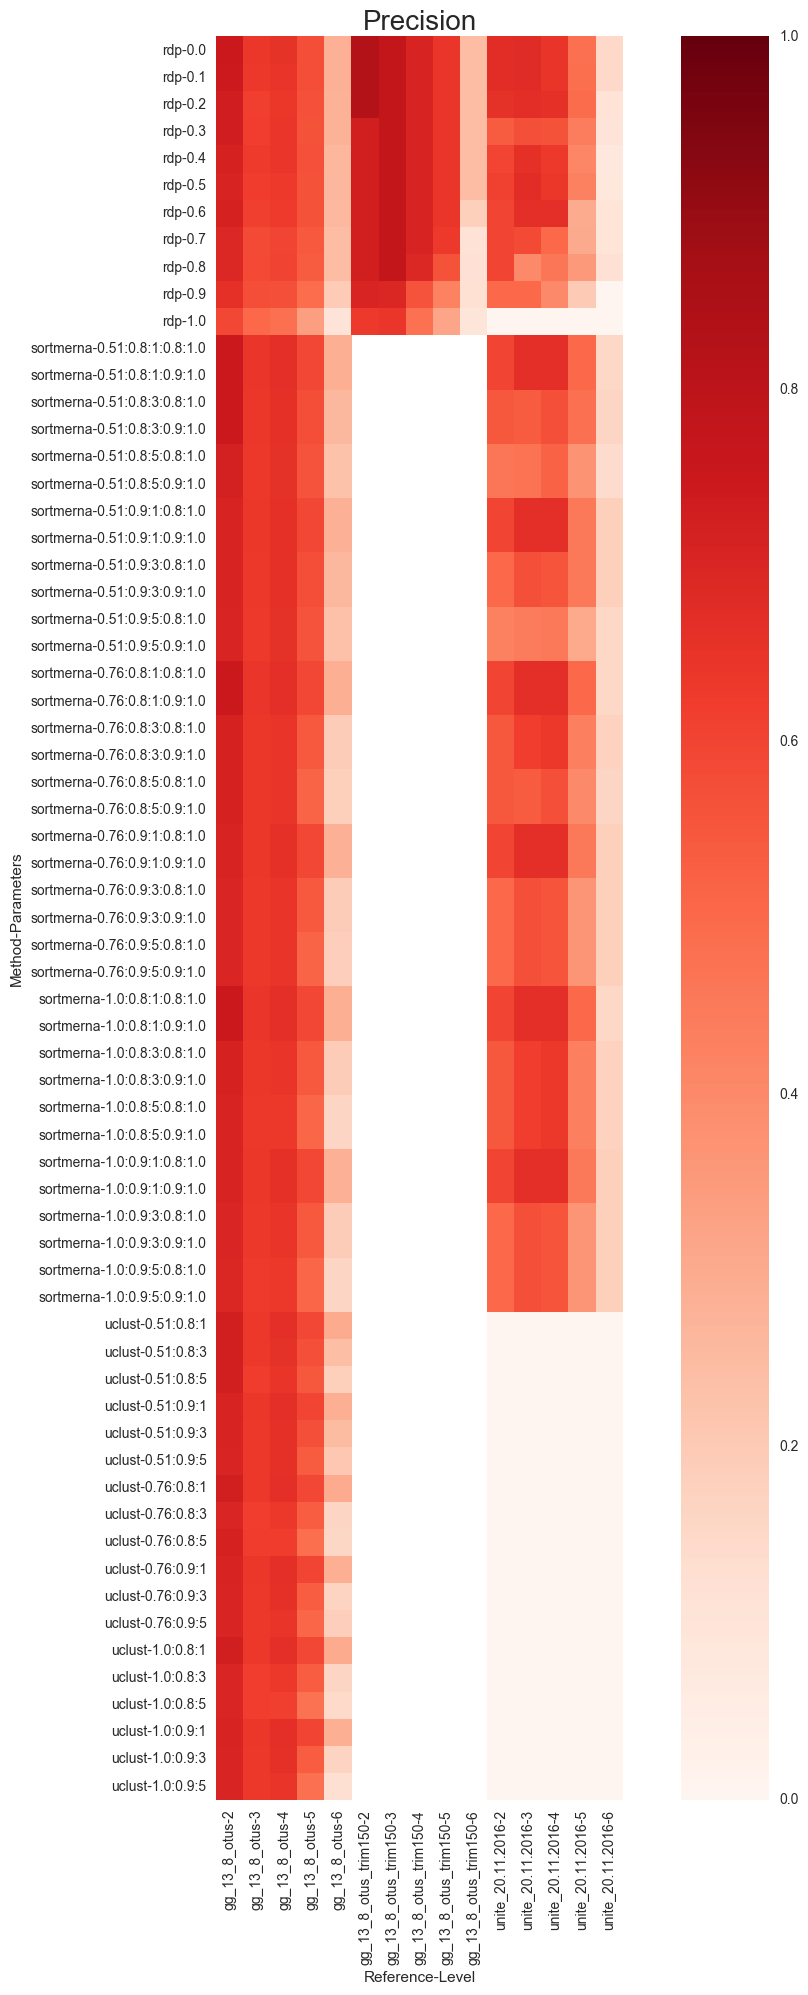

In [13]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

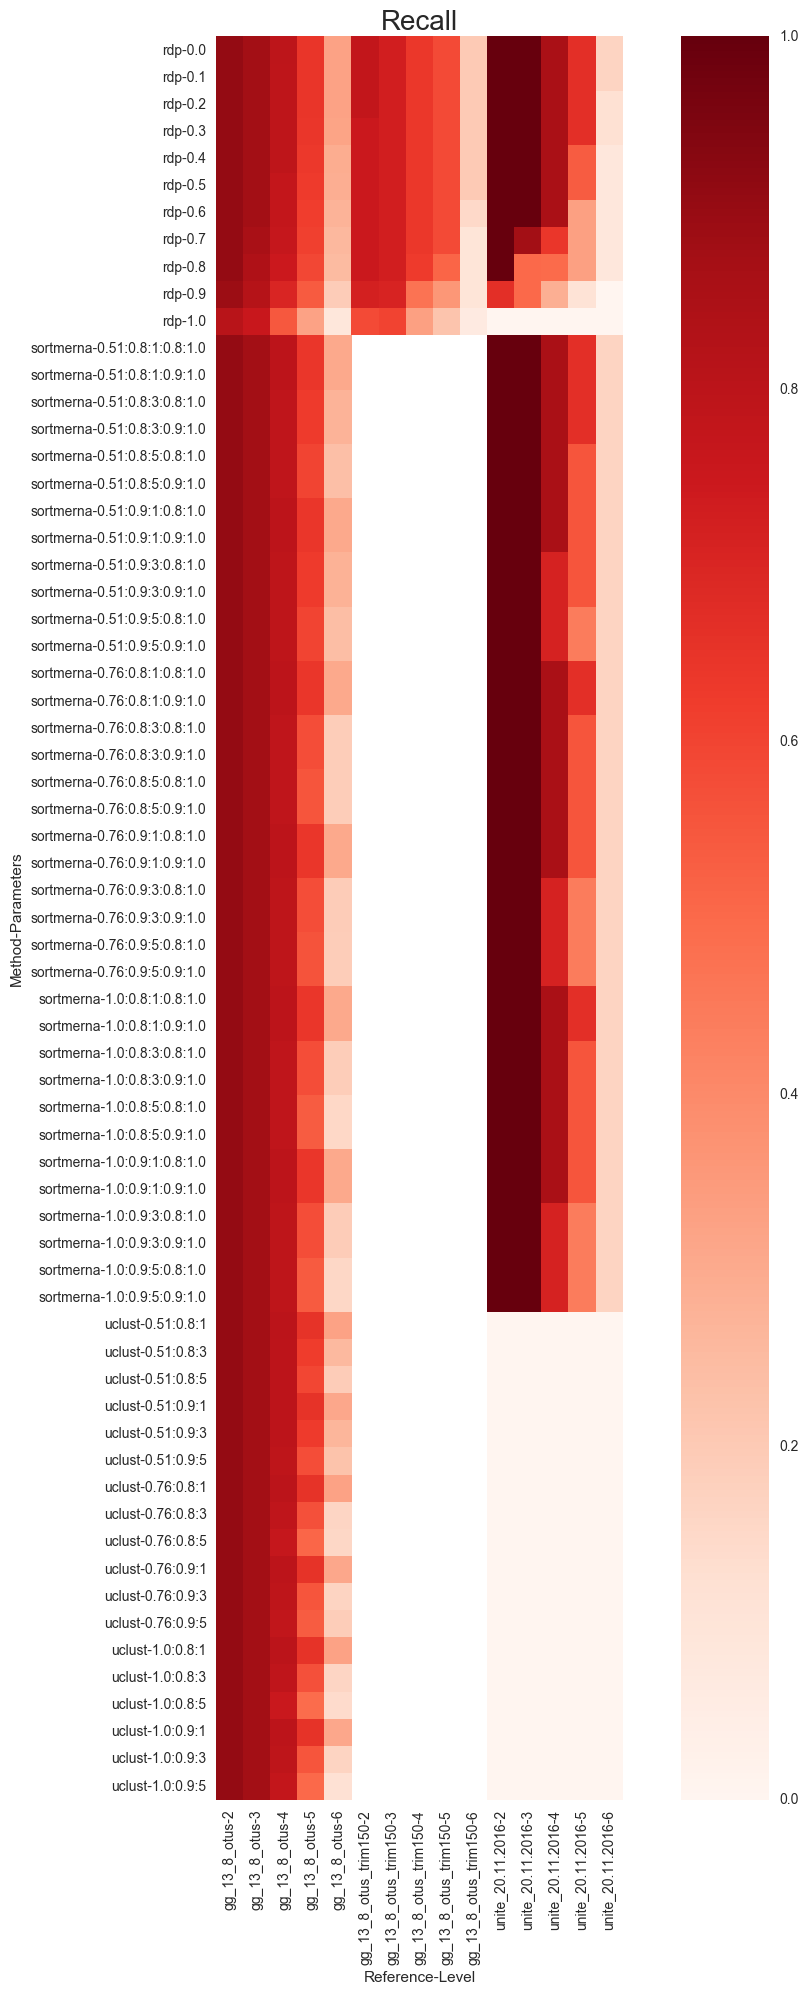

In [14]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

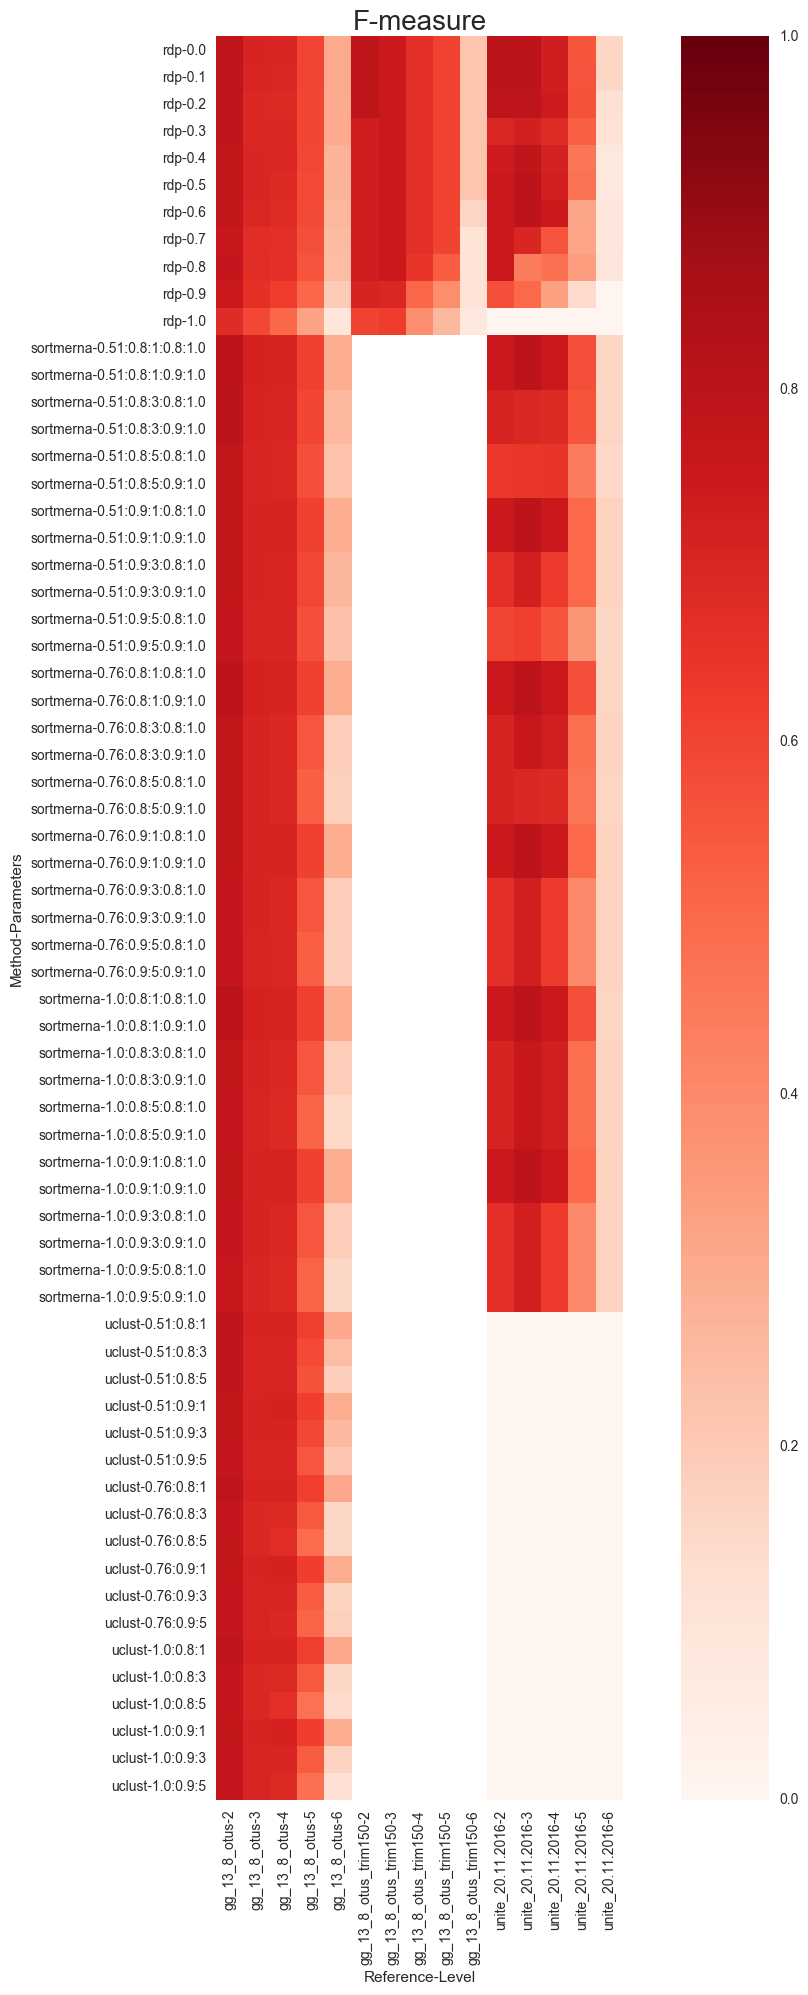

In [15]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

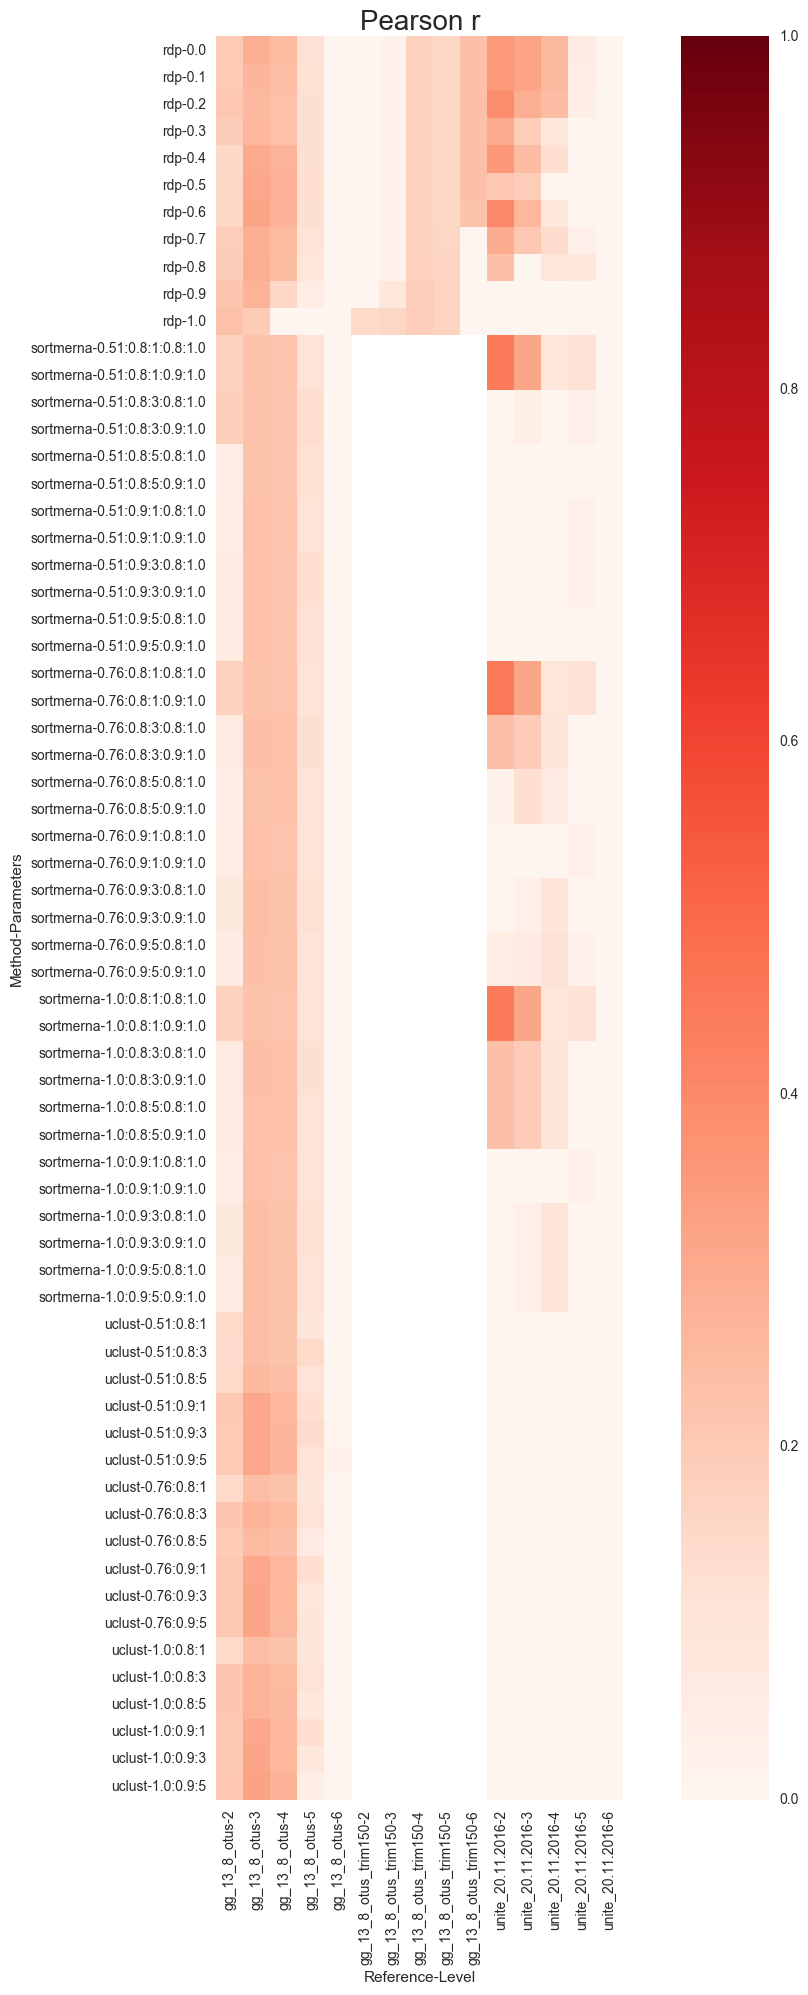

In [16]:
heatmap_from_data_frame(mock_results, metric="Pearson r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

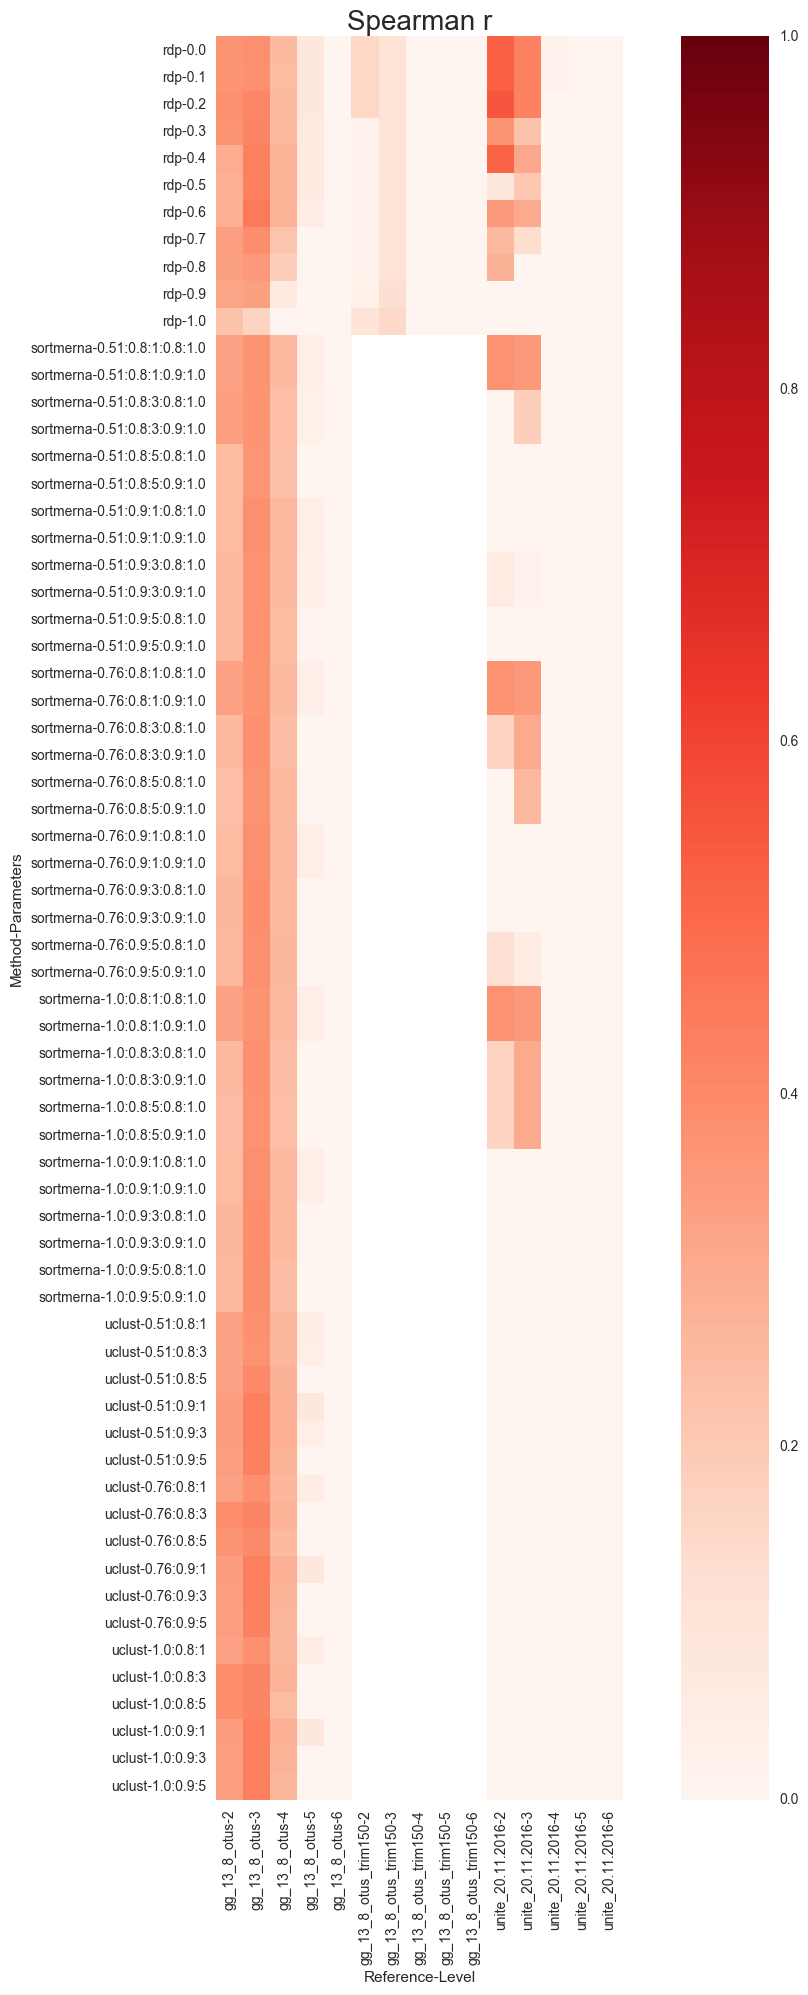

In [17]:
heatmap_from_data_frame(mock_results, metric="Spearman r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

Now we will focus on results at species level (for genus level, change to level 5)

In [18]:
mock_results_6 = mock_results[mock_results['Level'] == 6]

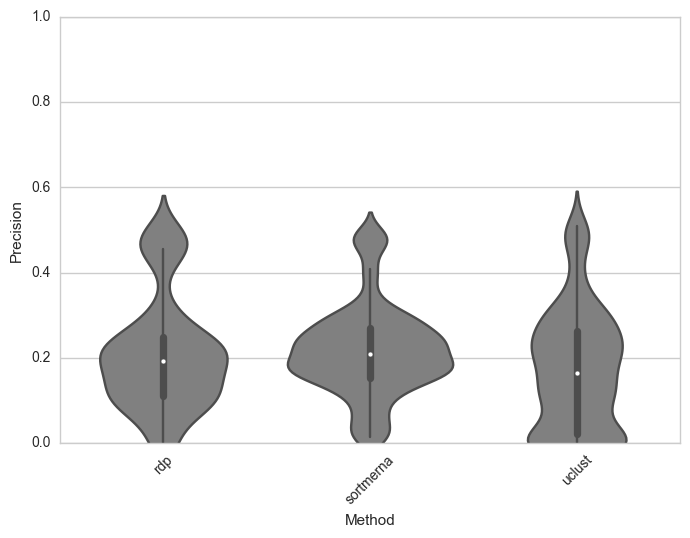

In [19]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Precision")

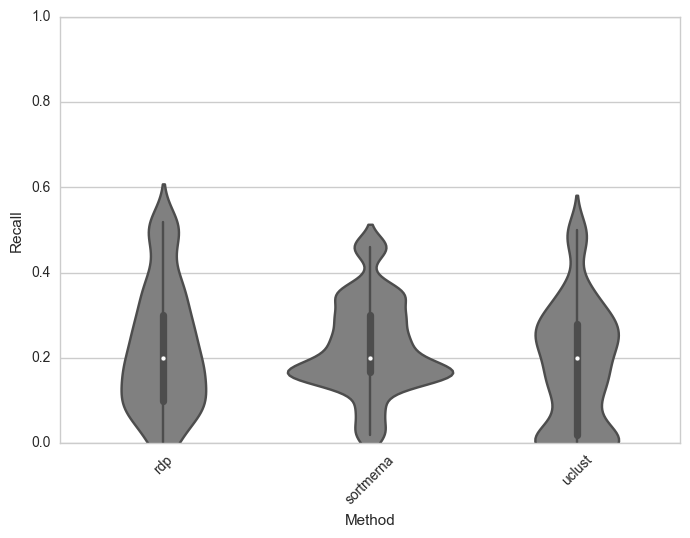

In [20]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Recall")

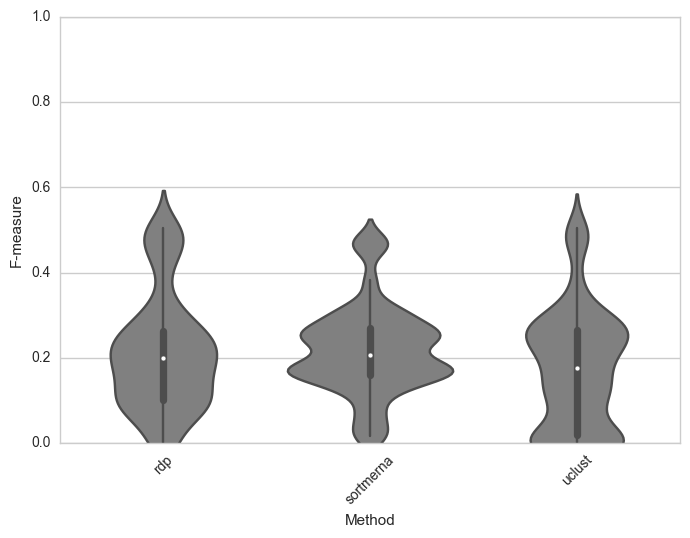

In [21]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="F-measure")

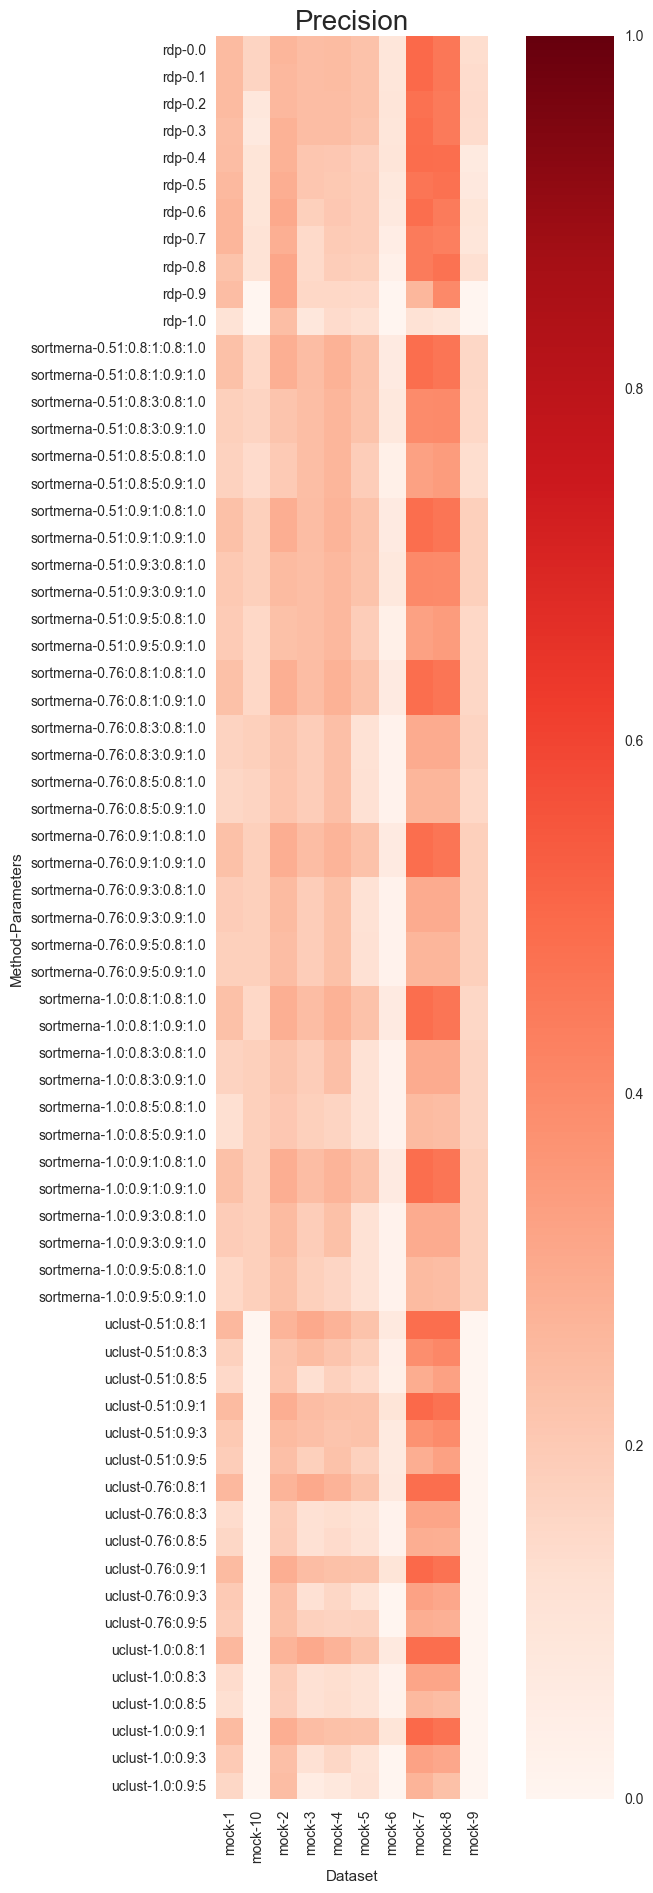

In [22]:
heatmap_from_data_frame(mock_results_6, "Precision")

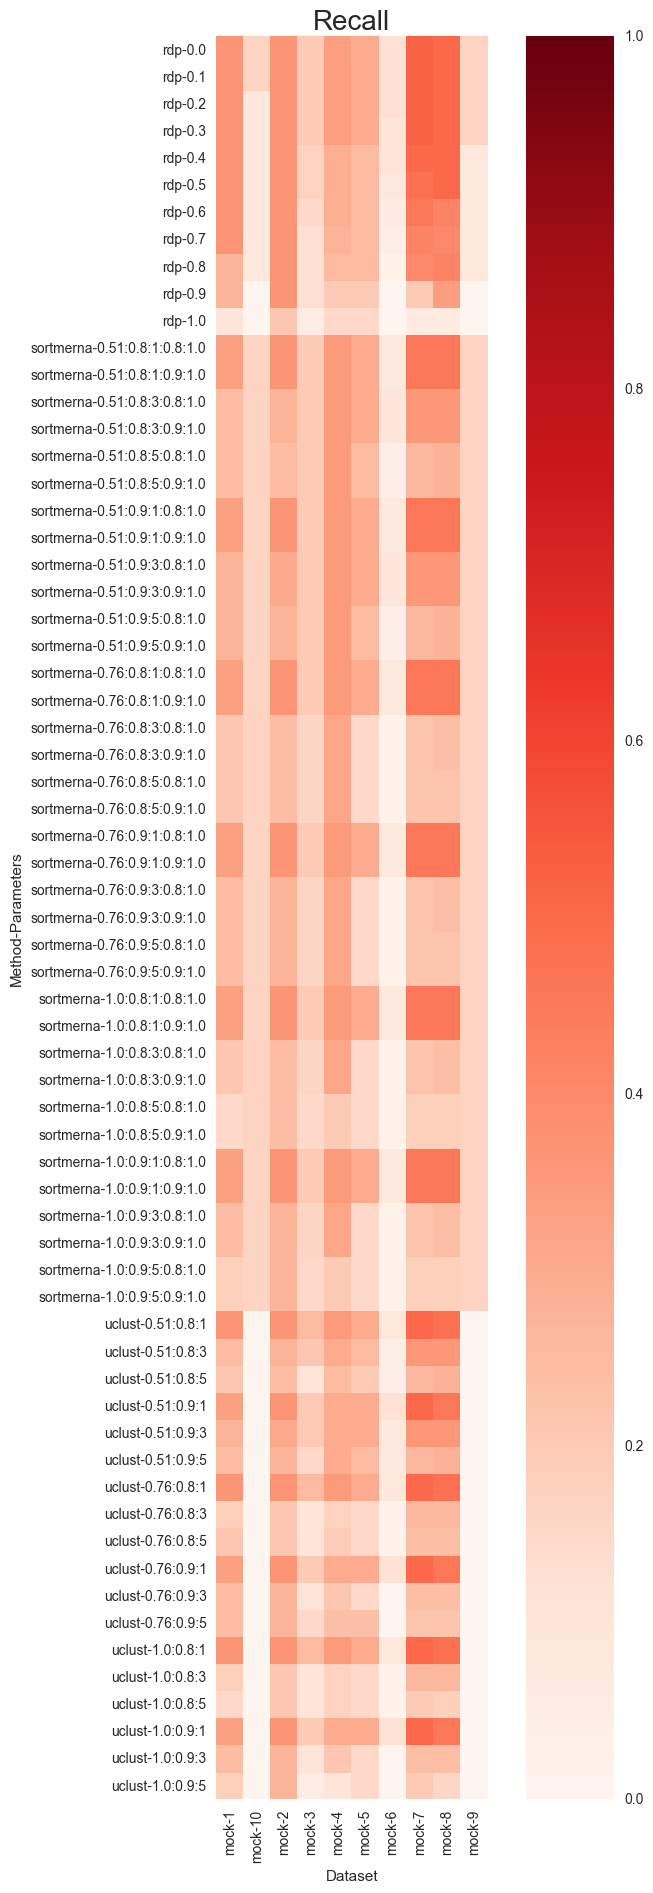

In [23]:
heatmap_from_data_frame(mock_results_6, "Recall")

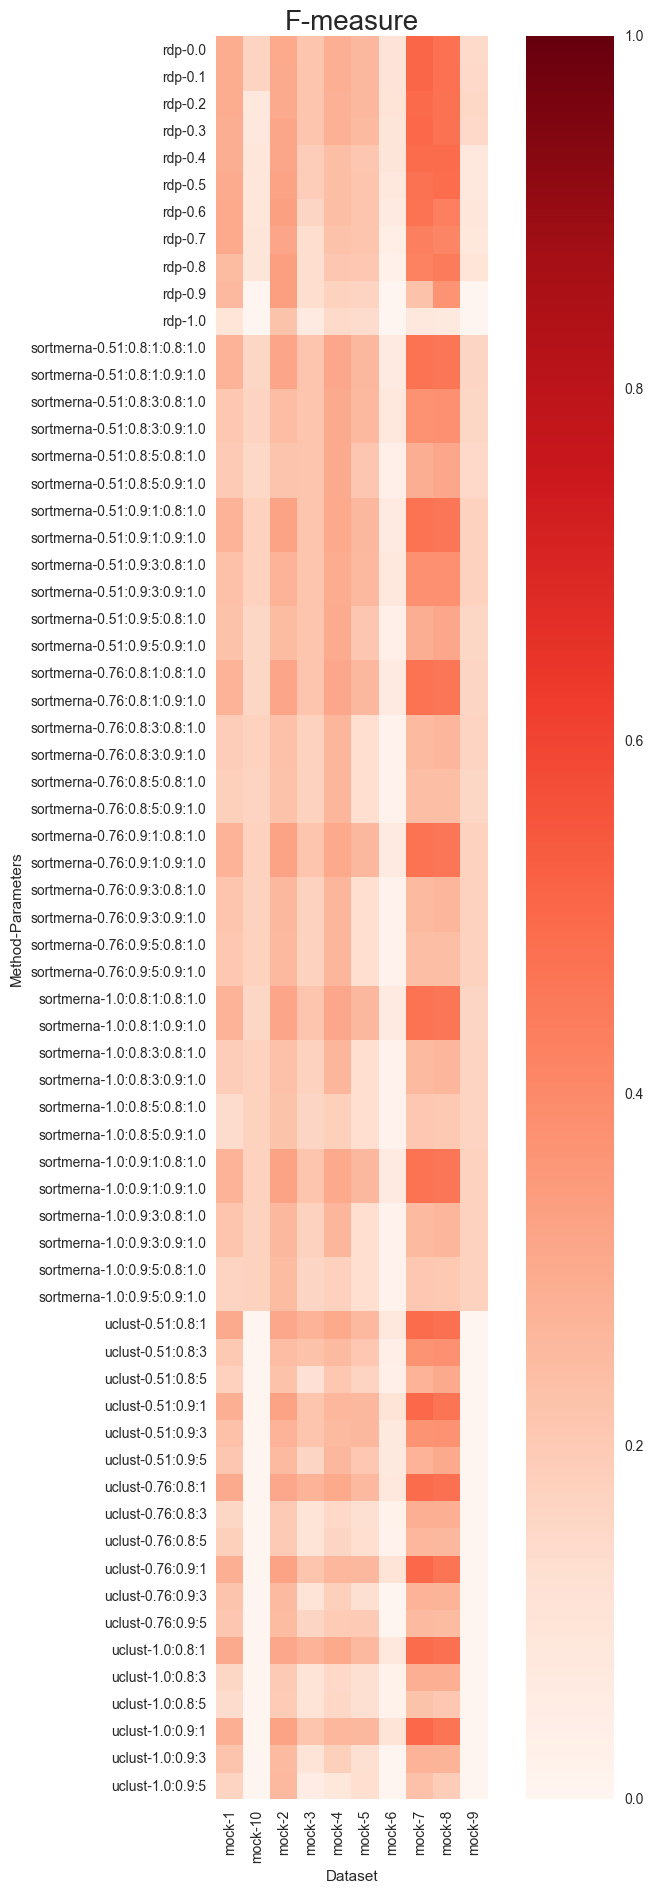

In [24]:
heatmap_from_data_frame(mock_results_6, "F-measure")

In [25]:
for i in range(1,11):
    print('mock-{0}'.format(i))
    best = method_by_dataset_a1(mock_results_6, 'mock-{0}'.format(i))
    display(best)

mock-1


Method  Precision    Recall  F-measure
39         rdp   0.266667  0.363636   0.307692
269     uclust   0.260870  0.363636   0.303797
179  sortmerna   0.234043  0.333333   0.275000

mock-2


Method  Precision    Recall  F-measure
1344        rdp   0.315789  0.363636   0.338028
1509  sortmerna   0.292683  0.363636   0.324324
1584     uclust   0.292683  0.363636   0.324324

mock-3


Method  Precision  Recall  F-measure
2823     uclust   0.384615    0.25   0.303030
2002  sortmerna   0.250000    0.25   0.250000
3042        rdp   0.238095    0.25   0.243902

mock-4


Method  Precision  Recall  F-measure
3621  sortmerna   0.304348    0.35   0.325581
4341     uclust   0.291667    0.35   0.318182
3161        rdp   0.269231    0.35   0.304348

mock-5


Method  Precision  Recall  F-measure
4462        rdp       0.25     0.3   0.272727
4862  sortmerna       0.25     0.3   0.272727
5702     uclust       0.25     0.3   0.272727

mock-6


Method  Precision  Recall  F-measure
6508     uclust   0.111111    0.12   0.115385
5788        rdp   0.105263    0.12   0.112150
5968  sortmerna   0.092593    0.10   0.096154

mock-7


Method  Precision  Recall  F-measure
6732        rdp   0.500000    0.52   0.509804
7482     uclust   0.510204    0.50   0.505051
7004  sortmerna   0.489362    0.46   0.474227

mock-8


Method  Precision  Recall  F-measure
7767        rdp   0.500000    0.50   0.500000
8502     uclust   0.500000    0.48   0.489796
7887  sortmerna   0.479167    0.46   0.469388

mock-9


Method  Precision    Recall  F-measure
9163  sortmerna   0.181818  0.166667   0.173913
8714        rdp   0.166667  0.166667   0.166667
9538     uclust   0.000000  0.000000   0.000000

mock-10


Method  Precision    Recall  F-measure
818   sortmerna   0.181818  0.166667   0.173913
338         rdp   0.166667  0.166667   0.166667
1298     uclust   0.000000  0.000000   0.000000

In [33]:
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(mock_results_6, method)
    print(method)
    display(top_params[:5])

rdp


F-measure  Pearson r  Precision  Recall  Spearman r
0.0         32         15         32      33          31
0.1         32         15         32      33          31
0.2         29         15         29      30          28
0.3         29         17         28      30          27
0.4         14         17         14      16          16

sortmerna


F-measure  Pearson r  Precision  Recall  Spearman r
0.76:0.9:1:0.8:1.0         29       17.0       29.0      29          22
1.0:0.9:1:0.9:1.0          29       17.0       29.0      29          22
1.0:0.9:1:0.8:1.0          29       17.0       29.0      29          22
0.51:0.9:1:0.8:1.0         29       17.0       29.0      29          22
0.51:0.9:1:0.9:1.0         29       17.0       29.0      29          22

uclust


F-measure  Pearson r  Precision  Recall  Spearman r
0.76:0.9:1         29         19         29      29          29
1.0:0.9:1          29         19         29      29          29
0.51:0.9:1         29         19         29      29          29
0.76:0.8:1         28         20         28      28          27
1.0:0.8:1          28         20         28      28          27

In [9]:
for dataset in mock_results['Reference'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(mock_results[mock_results["Level"] == level],
                                        group_by = 'Reference',
                                        dataset=dataset, sort_field="F-measure",
                                        display_fields=("Method", "Precision", "Recall", "F-measure"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

gg_13_8_otus level 4


Method  Precision    Recall  F-measure
7598     uclust   0.882353  0.882353   0.882353
6968  sortmerna   0.882353  0.882353   0.882353
6743        rdp   0.882353  0.882353   0.882353

gg_13_8_otus level 5


Method  Precision    Recall  F-measure
2098  sortmerna   0.777778  0.777778   0.777778
1658        rdp   0.777778  0.777778   0.777778
2758     uclust   0.777778  0.777778   0.777778

gg_13_8_otus level 6


Method  Precision  Recall  F-measure
6747        rdp   0.500000    0.52   0.509804
7572     uclust   0.510204    0.50   0.505051
7259  sortmerna   0.489362    0.46   0.474227

unite_20.11.2016 level 4


Method  Precision    Recall  F-measure
331         rdp   0.750000  0.857143       0.80
9023  sortmerna   0.666667  0.857143       0.75
1216     uclust   0.000000  0.000000       0.00

unite_20.11.2016 level 5


Method  Precision    Recall  F-measure
334         rdp   0.545455  0.666667   0.600000
8845  sortmerna   0.500000  0.666667   0.571429
9564     uclust   0.000000  0.000000   0.000000

unite_20.11.2016 level 6


Method  Precision    Recall  F-measure
9162  sortmerna   0.181818  0.166667   0.173913
338         rdp   0.166667  0.166667   0.166667
9552     uclust   0.000000  0.000000   0.000000

gg_13_8_otus_trim150 level 4


Method  Precision    Recall  F-measure
2994    rdp        0.7  0.777778   0.736842

gg_13_8_otus_trim150 level 5


Method  Precision    Recall  F-measure
2998    rdp       0.65  0.722222   0.684211

gg_13_8_otus_trim150 level 6


Method  Precision  Recall  F-measure
2942    rdp   0.238095    0.25   0.243902

Evaluation 2: Compute and summarize correlations between observed and known mock community structure
----------------------------------------------------------------------------------------------------

In this evaluation, we compute and summarize the correlation between each result (pre-computed and query) and the known composition of the mock communities. We then summarize the results in two ways: first with a series of boxplots of correlation coefficients by method; and second with a table of the top methods based on their Pearson correlation coefficient. 

This is a quantitative evaluation, which tells us about the ability of the different methods to report the taxa that are present in each sample and accurately assess their abundance. Because many factors can affect the observed abundance of taxa beyond the accuracy of the taxonomic assigner (e.g., primer bias), the correlation coefficients are frequently low, but we expect that their relative values are informative in understanding which taxonomic assigners are more correct than others.

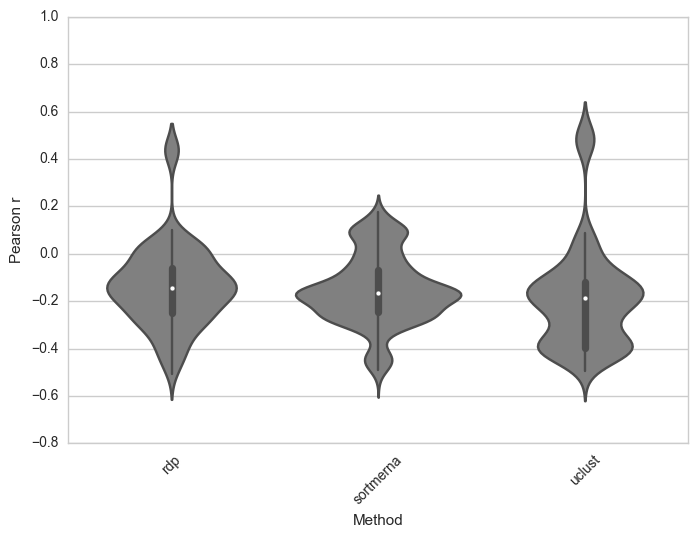

In [26]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Pearson r", y_min=None)

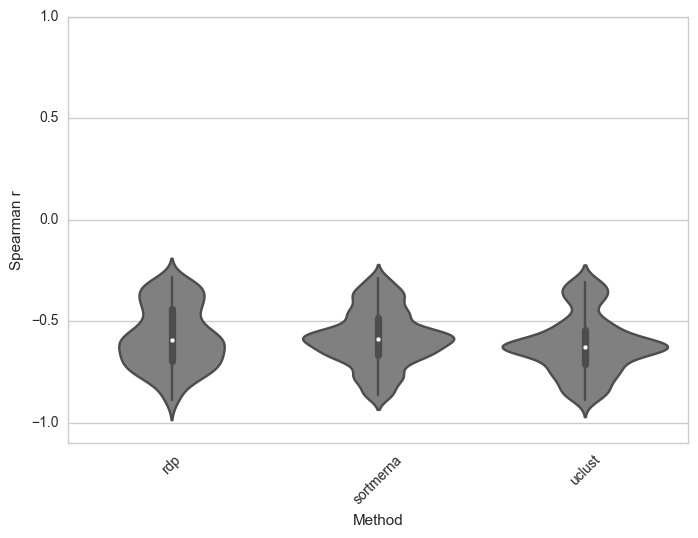

In [27]:
boxplot_from_data_frame(mock_results_6, group_by="Method", metric="Spearman r", y_min=None)

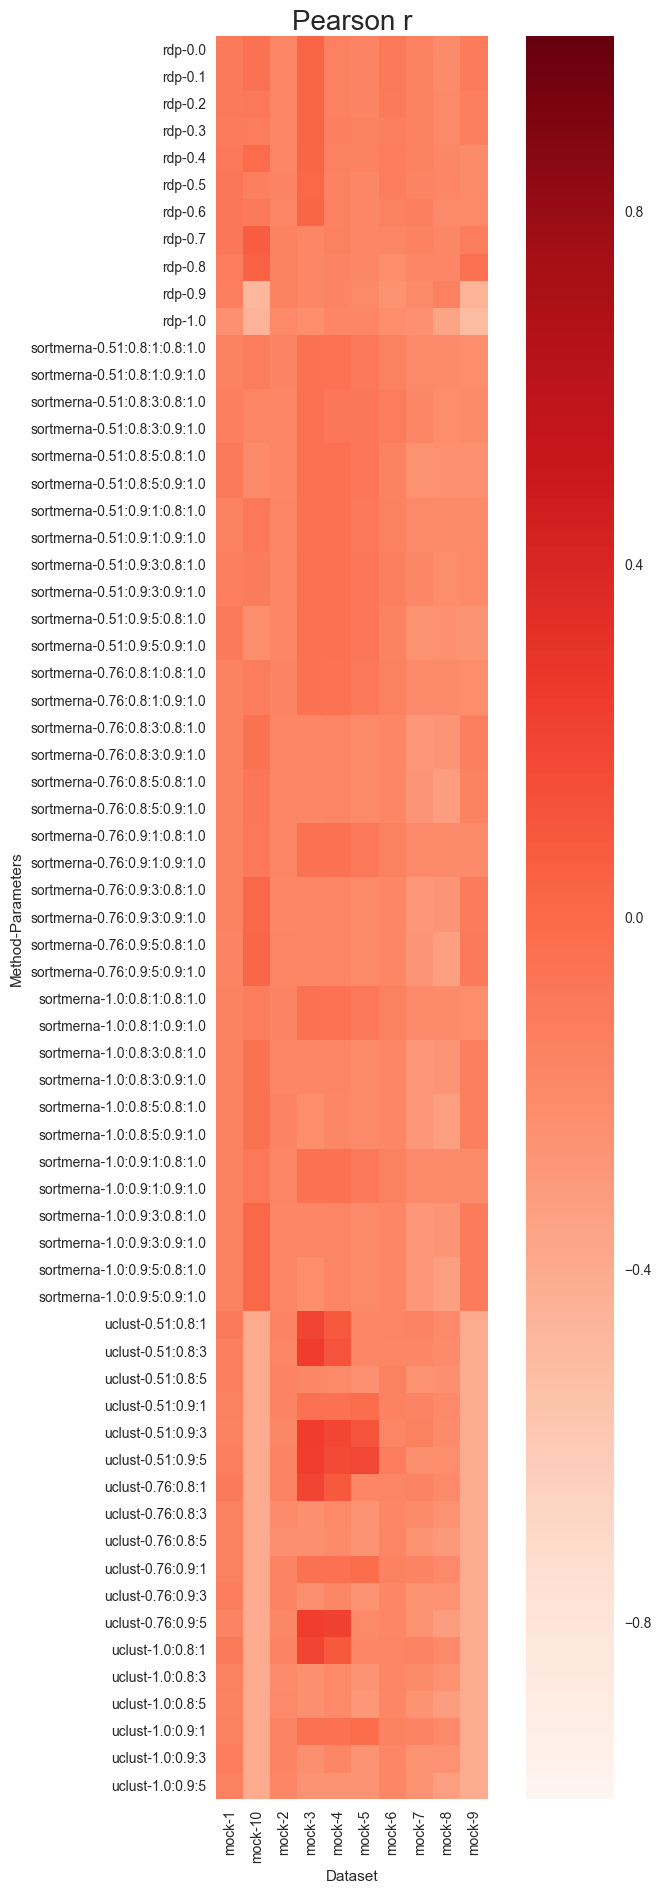

In [28]:
heatmap_from_data_frame(mock_results_6, "Pearson r", vmin=-1, vmax=1)

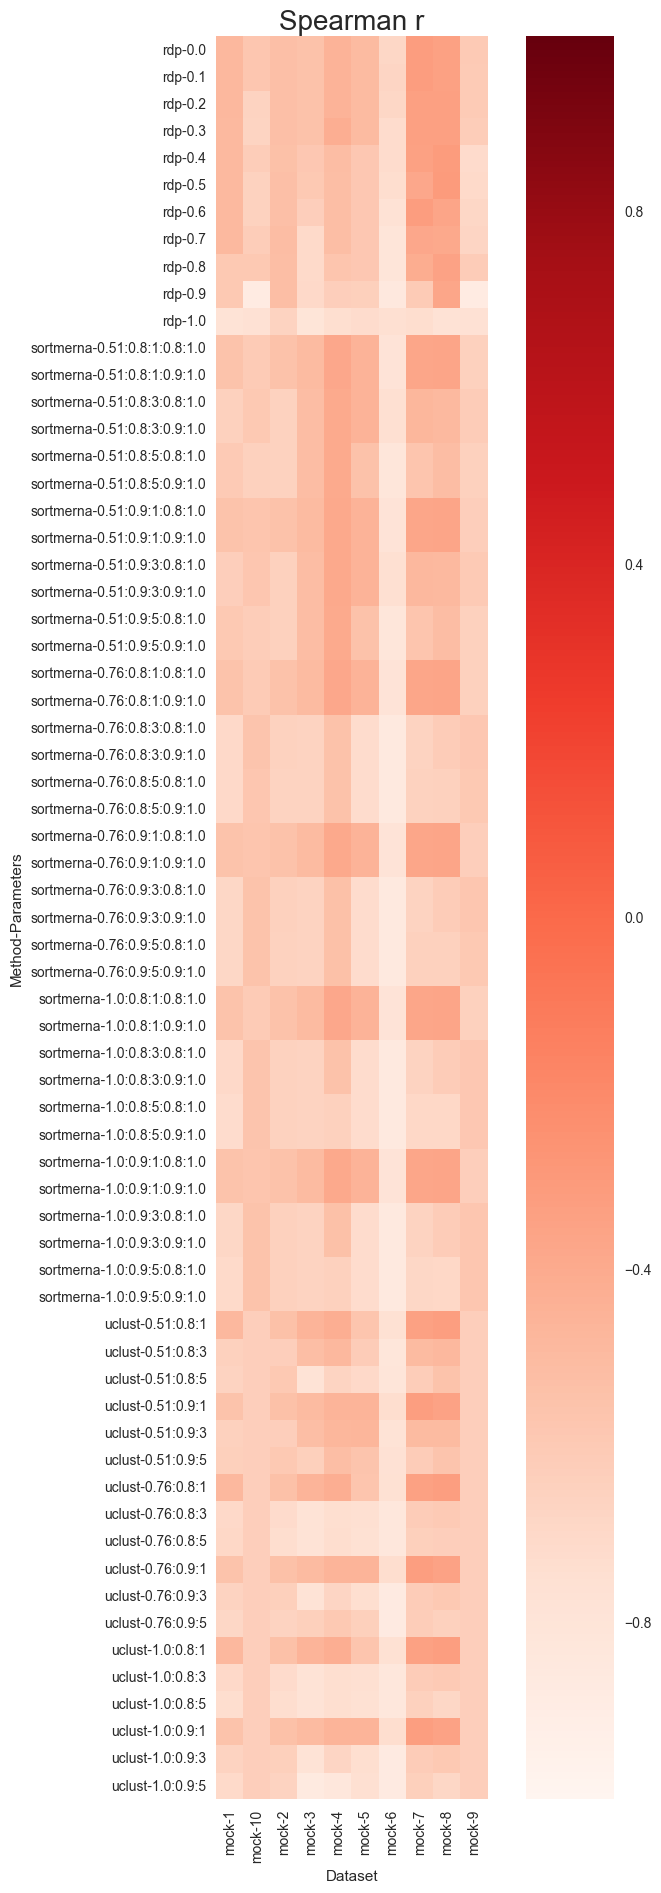

In [29]:
heatmap_from_data_frame(mock_results_6, "Spearman r", vmin=-1, vmax=1)

In [30]:
for i in range(1,11):
    print('mock-{0}'.format(i))
    best = method_by_dataset_a2(mock_results_6, 'mock-{0}'.format(i))
    display(best)

mock-1


Method  Pearson r  Spearman r
29         rdp  -0.081782   -0.486196
84   sortmerna  -0.096465   -0.600968
239     uclust  -0.097901   -0.477236

mock-2


Method  Pearson r  Spearman r
1349        rdp  -0.149546   -0.517347
1554     uclust  -0.157835   -0.532617
1479  sortmerna  -0.162878   -0.541736

mock-3


Method  Pearson r  Spearman r
2664     uclust   0.480148   -0.387470
3064        rdp   0.442654   -0.544173
2004  sortmerna  -0.002596   -0.431707

mock-4


Method  Pearson r  Spearman r
4184     uclust   0.515806   -0.388360
3644  sortmerna   0.174907   -0.292751
3344        rdp   0.090474   -0.566859

mock-5


Method  Pearson r  Spearman r
5504     uclust   0.497315   -0.493270
4744  sortmerna   0.104179   -0.383611
4644        rdp   0.075709   -0.580953

mock-6


Method  Pearson r  Spearman r
5772        rdp  -0.079175   -0.672652
5952  sortmerna  -0.111440   -0.722468
6537     uclust  -0.113501   -0.763751

mock-7


Method  Pearson r  Spearman r
6822        rdp  -0.119118   -0.296127
7498     uclust  -0.131351   -0.474867
6927  sortmerna  -0.160243   -0.464093

mock-8


Method  Pearson r  Spearman r
7842        rdp  -0.128417   -0.360510
8548     uclust  -0.170346   -0.347705
8068  sortmerna  -0.191006   -0.359207

mock-9


Method  Pearson r  Spearman r
8803        rdp   0.005774   -0.600326
9178  sortmerna  -0.058081   -0.584259
9523     uclust  -0.399004   -0.626067

mock-10


Method  Pearson r  Spearman r
397         rdp   0.099912   -0.606018
832   sortmerna   0.027353   -0.559899
1237     uclust  -0.399004   -0.626067

In [10]:
for dataset in mock_results['Reference'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(mock_results[mock_results["Level"] == level],
                                        group_by = 'Reference',
                                        dataset=dataset, sort_field="Pearson r",
                                        display_fields=("Method", "Pearson r", "Spearman r"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

gg_13_8_otus level 4


Method  Pearson r  Spearman r
3896  sortmerna   0.629785    0.493198
4216     uclust   0.616306    0.489602
5751        rdp   0.579482    0.416122

gg_13_8_otus level 5


Method  Pearson r  Spearman r
4120     uclust   0.842577    0.447909
3420  sortmerna   0.796196    0.447372
3260        rdp   0.577982    0.470572

gg_13_8_otus level 6


Method  Pearson r  Spearman r
4184     uclust   0.515806   -0.388360
3864  sortmerna   0.174907   -0.292751
3344        rdp   0.090474   -0.566859

unite_20.11.2016 level 4


Method  Pearson r  Spearman r
331         rdp   0.445427   -0.055048
511   sortmerna   0.293655    0.032781
1126     uclust  -0.449653   -0.661438

unite_20.11.2016 level 5


Method  Pearson r  Spearman r
694   sortmerna   0.268275    0.023499
334         rdp   0.225712   -0.224944
9581     uclust  -0.424706   -0.642529

unite_20.11.2016 level 6


Method  Pearson r  Spearman r
397         rdp   0.099912   -0.606018
832   sortmerna   0.027353   -0.559899
1282     uclust  -0.399004   -0.626067

gg_13_8_otus_trim150 level 4


Method  Pearson r  Spearman r
3135    rdp    0.31669   -0.115529

gg_13_8_otus_trim150 level 5


Method  Pearson r  Spearman r
3139    rdp   0.263707   -0.396348

gg_13_8_otus_trim150 level 6


Method  Pearson r  Spearman r
3064    rdp   0.442654   -0.544173